# Proximal Policy Optimization


## Introduction

This code example solves the CartPole-v0 environment using a Proximal Policy Optimization (PPO) agent.


### Proximal Policy Optimization

PPO is a policy gradient method and can be used for environments with either discrete or continuous action spaces.
It trains a stochastic policy in an on-policy way. Also, it utilizes the actor critic method. The actor maps the
observation to an action and the critic gives an expectation of the rewards of the agent for the observation given.
Firstly, it collects a set of trajectories for each epoch by sampling from the latest version of the stochastic policy.
Then, the rewards-to-go and the advantage estimates are computed in order to update the policy and fit the value function.
The policy is updated via a stochastic gradient ascent optimizer, while the value function is fitted via some gradient descent algorithm.
This procedure is applied for many epochs until the environment is solved.

![Algorithm](https://i.imgur.com/rd5tda1.png)

- [PPO Original Paper](https://arxiv.org/pdf/1707.06347.pdf)
- [OpenAI Spinning Up docs - PPO](https://spinningup.openai.com/en/latest/algorithms/ppo.html)

### Note

This code example uses Keras and Tensorflow v2. It is based on the PPO Original Paper,
the OpenAI's Spinning Up docs for PPO, and the OpenAI's Spinning Up implementation of PPO using Tensorflow v1.

[OpenAI Spinning Up Github - PPO](https://github.com/openai/spinningup/blob/master/spinup/algos/tf1/ppo/ppo.py)

## Libraries

For this example the following libraries are used:

1. `numpy` for n-dimensional arrays
2. `tensorflow` and `keras` for building the deep RL PPO agent
3. `gym` for getting everything we need about the environment
4. `scipy.signal` for calculating the discounted cumulative sums of vectors

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym
import scipy.signal
import time
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
%run utils.ipynb
%run torque_dynamics.ipynb

## Hyperparameters

In [3]:
# Hyperparameters of the PPO algorithm
steps_per_epoch = 500
epochs = 1000
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.95
target_kl = 0.01
hidden_sizes = (400, 300)

# True if you want to render the environment
render = False

## Physics

In [4]:
def gravity_gradient_torque(quat, inertia_tensor, mean_motion):
    Ae3 = rotate_vec_with_quat(quat, np.array([0., 0., 1.]))

    return 3. * mean_motion ** 2. * cross_product(Ae3, inertia_tensor.dot(Ae3))    


def rhs(t, x, sat, action):

    quat = x[:4] / np.linalg.norm(x[:4])
    omega = x[4:7]
    h = x[7:10]
     
    omega_rel = omega - rotate_vec_with_quat(quat, np.array([0., sat.mean_motion, 0.]))    
        
    trq_gg = gravity_gradient_torque(quat, sat.J, sat.mean_motion)       

    x_dot = np.zeros(10)
    action = action.reshape(3,)
    x_dot[0] = -0.5 * quat[1:].dot(omega_rel)
    x_dot[1:4] = 0.5 * (quat[0] * omega_rel + cross_product(quat[1:], omega_rel))
    tmp3 = (trq_gg + action - cross_product(omega, sat.J.dot(omega)))
    x_dot[4:7] = sat.J_inv.dot(tmp3)
    x_dot[7:10] = - action

    return x_dot

## Initializations

In [5]:
# Initialize the environment and get the dimensionality of the
# observation space and the number of possible actions
env = TorqueDynamics(0.1, np.array([1, 0, 0, 0]), 0.05)
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

# Initialize the buffer
buffer = Buffer(observation_dimensions, steps_per_epoch)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)
logits = mlp(observation_input, list(hidden_sizes) + [num_actions], tf.nn.relu, None)
actor = keras.Model(inputs=observation_input, outputs=logits)
value = tf.squeeze(
    mlp(observation_input, list(hidden_sizes) + [1], tf.nn.relu, None), axis=1
)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)



## Train

In [ ]:
%%notify
print('Accounting for the gravity')
iterations = 20
reward_thresh = 0.1
tries = 100

for i in range(tries):
  print(f'Run #{i}. The "+9" threshold is {reward_thresh}')
  mean_ret = train(iterations, reward_thresh)
  mean_ret = np.min(mean_ret)
  print(f'Current batch mean is {mean_ret}')
  print('-'*10)
  if mean_ret > 5000 and reward_thresh > 0.004:
    reward_thresh *= 0.5# - 3*(mean_ret - 1000)/40000 # linear from (1000, 0.8) to (5000, 0.5)
  

## Display results

In [15]:
# %%notify
observation = env.reset()
episode_return = 0
# Iterate over the steps of each epoch
for t in range(steps_per_epoch*2):
    if render:
        env.render()

    # Get the logits, action, and take one step in the environment
    observation = observation.reshape(1, -1)
    logits, action = sample_action(observation)
    #print(type(action[0].numpy()))
    observation_new, reward, done, info = env.step(action[0].numpy())
    episode_return += reward

    # Update the observation
    observation = observation_new
print(episode_return)

5445.6847872349035


means:
roll=-0.11616080302863417	pitch=-0.04805721001011869	yaw=0.2492969185381175
std:
roll=0.10563390072362171	pitch=0.1600666871585189	yaw=0.07555892159063343


C:\Users\imjob\AppData\Local\Temp/ipykernel_2332/3660080882.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


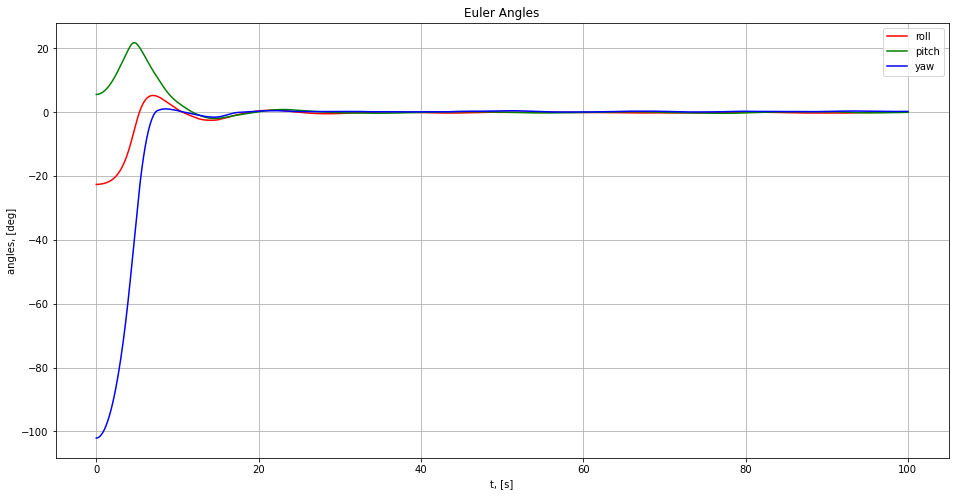

In [19]:
x = np.array(info['x'])
t = np.array(info['t'])
roll, pitch, yaw = quat2rpy_deg(x[:,0], x[:,1], x[:,2], x[:,3])
size = roll.shape[0]//3
print(f'means:\nroll={np.mean(roll[-size:])}\tpitch={np.mean(pitch[-size:])}\tyaw={np.mean(yaw[-size:])}\n\
std:\nroll={np.std(roll[-size:])}\tpitch={np.std(pitch[-size:])}\tyaw={np.std(yaw[-size:])}')

plot_euler_angles(t, roll, pitch, yaw, filename='angles2.pdf', inset=True)

In [ ]:
start = np.array([np.cos(np.pi/2),0,0,np.sin(np.pi/2),0,0,0,0,0,0])

In [ ]:
roll, pitch, yaw = quat2rpy_deg(x[:,0], x[:,1], x[:,2], x[:,3])
   
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(2,2,1)

ax1.set_title("Euler Angles")
ax1.plot(t, roll, label = 'roll', color = 'red')
ax1.plot(t, pitch, label = 'pitch', color = 'green')
ax1.plot(t, yaw, label = 'yaw', color = 'blue')
ax1.set_ylabel(r'angles, [deg]')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()

ax2 = fig1.add_subplot(2,2,2)

ax2.set_title("Angular Velocity")
ax2.plot(t, x[:,4], label = '$\omega_x$', color = 'red')
ax2.plot(t, x[:,5], label = '$\omega_y$', color = 'green')
ax2.plot(t, x[:,6], label = '$\omega_z$', color = 'blue')
ax2.set_ylabel(r'angular velocity, [rad/s]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

ax2 = fig1.add_subplot(2,2,3)

ax2.set_title("RW angular momentum")
ax2.plot(t, x[:,7], label = '$h_x$', color = 'red')
ax2.plot(t, x[:,8], label = '$h_y$', color = 'green')
ax2.plot(t, x[:,9], label = '$h_z$', color = 'blue')
ax2.set_ylabel(r'h, [Nms]')
ax2.set_xlabel(r't, [s]')
ax2.grid(True)
ax2.legend()

plt.tight_layout()

## Saving the weights

In [ ]:
actor_config = actor.get_config()
actor_weights = actor.get_weights()
critic_config = critic.get_config()
critic_weights = critic.get_weights()
import pickle
name = f'configs_weights_sin{iterations} {reward_thresh}.pickle'
with open(name, 'wb') as f:
  pickle.dump((actor_config, actor_weights, critic_config, critic_weights), f)

## Importing the weights

In [7]:
import pickle
# iterations = 1500
# reward_thresh = 0.0043
name = f'data/configs_weights.pickle'
with open(name, 'rb') as f:
  something = pickle.load(f)

actor_config, actor_weights ,critic_config, critic_weights = something
actor = keras.Model.from_config(actor_config)
actor.set_weights(actor_weights)
critic = keras.Model.from_config(critic_config)
critic.set_weights(critic_weights)